In [1]:
# Importing Necessary Libraries
import tensorflow
import google
import cv2
import PIL
import matplotlib
import numpy
import pandas
import sklearn
import os
import glob

In [2]:
# Kaggle API Authentication
!pip install -q kaggle
google.colab.files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle (1).json
kaggle.json


In [3]:
# Downloading and Unzipping The Dataset
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000
!unzip -q skin-cancer-mnist-ham10000.zip

skin-cancer-mnist-ham10000.zip: Skipping, found more recently modified local copy (use --force to force download)
replace HAM10000_images_part_1/ISIC_0024306.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [4]:
# Dataset Preprocessing
base_directory = os.path.join("/content")

image_paths = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob.glob(os.path.join(base_directory, '*', '*.jpg'))}

lesions = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}     

dataframe = pandas.read_csv(os.path.join(base_directory, 'HAM10000_metadata.csv'))

dataframe['path'] = dataframe['image_id'].map(image_paths.get)
dataframe['cell_type'] = dataframe['dx'].map(lesions.get) 
dataframe['cell_type_idx'] = pandas.Categorical(dataframe['cell_type']).codes

dataframe.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/ham10000_images_part_1/ISIC_0027419.jpg,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/ham10000_images_part_1/ISIC_0025030.jpg,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/ham10000_images_part_1/ISIC_0026769.jpg,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/ham10000_images_part_1/ISIC_0025661.jpg,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/content/HAM10000_images_part_2/ISIC_0031633.jpg,Benign keratosis-like lesions,2


In [5]:
# Checking For Empty Values
dataframe.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [6]:
# Filling In Empty Values 
dataframe['age'].fillna((dataframe['age'].mean()), inplace = True)

In [7]:
# Checking for Empty Values 
dataframe.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
path             0
cell_type        0
cell_type_idx    0
dtype: int64

In [9]:
dataframe['image'] = dataframe['path'].map(lambda x: numpy.asarray(PIL.Image.open(x).resize((100, 75))))

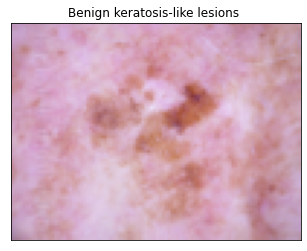

In [11]:
# Visualizing a Training Sample
matplotlib.pyplot.figure()
matplotlib.pyplot.imshow(dataframe['image'][0])
matplotlib.pyplot.xticks([])
matplotlib.pyplot.yticks([])
matplotlib.pyplot.title(dataframe["cell_type"][0])
matplotlib.pyplot.show()

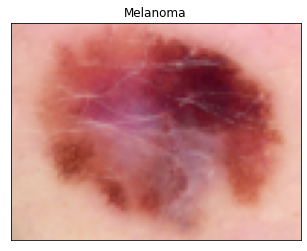

In [12]:
# Visualizing a Training Sample
matplotlib.pyplot.figure()
matplotlib.pyplot.imshow(dataframe['image'][2000])
matplotlib.pyplot.xticks([])
matplotlib.pyplot.yticks([])
matplotlib.pyplot.title(dataframe["cell_type"][2000])
matplotlib.pyplot.show()

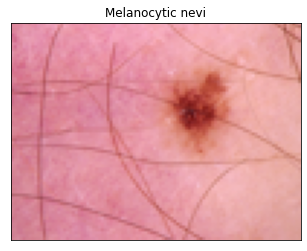

In [13]:
# Visualizing a Training Sample
matplotlib.pyplot.figure()
matplotlib.pyplot.imshow(dataframe['image'][3000])
matplotlib.pyplot.xticks([])
matplotlib.pyplot.yticks([])
matplotlib.pyplot.title(dataframe["cell_type"][3000])
matplotlib.pyplot.show()

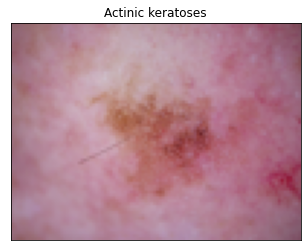

In [14]:
# Visualizing a Training Sample
matplotlib.pyplot.figure()
matplotlib.pyplot.imshow(dataframe['image'][10000])
matplotlib.pyplot.xticks([])
matplotlib.pyplot.yticks([])
matplotlib.pyplot.title(dataframe["cell_type"][10000])
matplotlib.pyplot.show()

In [16]:
from sklearn.model_selection import train_test_split
features = dataframe.drop(columns = ['cell_type_idx'], axis = 1)
target = dataframe['cell_type_idx']

X_train_o, X_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size = 0.1)

X_train = numpy.asarray(X_train_o['image'].tolist())
X_test = numpy.asarray(X_test_o['image'].tolist())

X_train = X_train / 255.0
X_test = X_test / 255.0

X_train = X_train.reshape(X_train.shape[0], *(75, 100, 3))
X_test = X_test.reshape(X_test.shape[0], *(75, 100, 3))

y_train = tensorflow.keras.utils.to_categorical(y_train_o, num_classes = 7)
y_test = tensorflow.keras.utils.to_categorical(y_test_o, num_classes = 7)

In [17]:
image_generator = tensorflow.keras.preprocessing.image.ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True,
)

In [19]:
training_image_generator = image_generator.flow(X_train, y_train, save_to_dir = "/content/Augmented_Images")

In [23]:
mobilenet = tensorflow.keras.applications.mobilenet.MobileNet(input_shape = (75, 100, 3), include_top = False)
mobilenet.summary()

17227776/17225924 [==============================] - 0s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 75, 100, 3)]      0         
_________________________________________________________________
conv1 (Conv2D)               (None, 38, 50, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 38, 50, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 38, 50, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 38, 50, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 38, 50, 32)        128       
_________________________________________________

In [25]:
x = mobilenet.layers[-6].output
x = tensorflow.keras.layers.Dense(units = 256, activation = "relu")(x)
x = tensorflow.keras.layers.Dense(units = 256, activation = "relu")(x)
predictions = tensorflow.keras.layers.Dense(units = 7, activation = "softmax")(x)

model = tensorflow.keras.models.Model(inputs = mobilenet.input, outputs = predictions)

In [ ]:
import time
time.sleep(3600)

In [27]:
predictions = tensorflow.keras.layers.Dense(units = 7, activation = "softmax")(x)

In [28]:
model = tensorflow.keras.models.Model(inputs = model.input, outputs = predictions)

In [29]:
model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [30]:
model.fit(training_image_generator, epochs = 50, callbacks = tensorflow.keras.callbacks.EarlyStopping(monitor = "loss", patience = 5, mode = "min", restore_best_weights = True))

Epoch 1/50
282/282 [==============================] - 21s 65ms/step - loss: 1.2117 - accuracy: 0.6460
Epoch 2/50
282/282 [==============================] - 18s 64ms/step - loss: 0.7358 - accuracy: 0.7476
Epoch 3/50
282/282 [==============================] - 18s 64ms/step - loss: 0.6245 - accuracy: 0.7698
Epoch 4/50
282/282 [==============================] - 18s 64ms/step - loss: 0.6087 - accuracy: 0.7745
Epoch 5/50
282/282 [==============================] - 18s 65ms/step - loss: 0.5675 - accuracy: 0.7922
Epoch 6/50
282/282 [==============================] - 18s 64ms/step - loss: 0.5669 - accuracy: 0.7975
Epoch 7/50
282/282 [==============================] - 18s 65ms/step - loss: 0.5177 - accuracy: 0.8140
Epoch 8/50
282/282 [==============================] - 18s 64ms/step - loss: 0.5330 - accuracy: 0.8021
Epoch 9/50
282/282 [==============================] - 18s 64ms/step - loss: 0.5321 - accuracy: 0.8043
Epoch 10/50
282/282 [==============================] - 18s 65ms/step - loss: 0.517

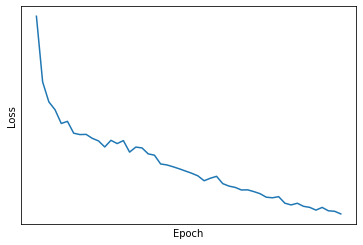

In [31]:
# Visualizing The Optimization
matplotlib.pyplot.figure()
matplotlib.pyplot.plot(model.history.epoch, model.history.history["loss"])
matplotlib.pyplot.xticks([])
matplotlib.pyplot.xlabel("Epoch")
matplotlib.pyplot.yticks([])
matplotlib.pyplot.ylabel("Loss")
matplotlib.pyplot.show()

In [34]:
image_generator = tensorflow.keras.preprocessing.image.ImageDataGenerator()

In [35]:
testing_image_generator = image_generator.flow(X_test, y_test)

In [37]:
# Examining The Testing Accuracy
print("Testing Accuracy: {}%".format(((model.evaluate(testing_image_generator)[1] * 100))))

32/32 [==============================] - 1s 15ms/step - loss: 0.5778 - accuracy: 0.8214
Testing Accuracy: 82.13573098182678%


In [40]:
# Visualizing a Random Prediction
def visualize_prediction(file_path, actual): 
  matplotlib.pyplot.figure() 
  image = numpy.asarray(PIL.Image.open(file_path).resize((100, 75)))
  matplotlib.pyplot.imshow(image)
  image = image / 255.0
  image = numpy.resize(image, (1, 75, 100, 3))
  image_generator = tensorflow.keras.preprocessing.image.ImageDataGenerator()
  image_gen = image_generator.flow(image)
  prediction = model.predict(image_gen)
  classes = {0: "Actinic Keratoses/Intraepithelial Carcinoma (akiec)",
             1: "Basal Cell Carcinoma (bcc)",
             2: "Benign Keratosis-Like Lesions (bkl)",
             3: "Dermatofibroma (df)",
             4: "Melanoma (mel)",
             5: "Melanocytic Nevi (nv)",
             6: "Vascular Lesions (vasc)"}
  prediction = classes[prediction.argmax()]
  matplotlib.pyplot.xticks([])
  matplotlib.pyplot.title("Prediction: {}\nActual: {}".format(prediction, actual))
  matplotlib.pyplot.yticks([])
  matplotlib.pyplot.show()

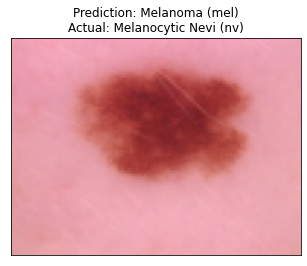

In [64]:
visualize_prediction(file_path = "/content/ham10000_images_part_1/ISIC_0025042.jpg", actual = "Melanocytic Nevi (nv)")

In [58]:
dataframe.sample(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
6628,HAM_0003547,ISIC_0027921,nv,follow_up,50.0,male,lower extremity,/content/ham10000_images_part_1/ISIC_0027921.jpg,Melanocytic nevi,4,"[[[221, 148, 172], [221, 148, 172], [223, 150,..."
8050,HAM_0005972,ISIC_0033319,nv,histo,35.0,female,lower extremity,/content/HAM10000_images_part_2/ISIC_0033319.jpg,Melanocytic nevi,4,"[[[133, 85, 78], [138, 90, 80], [145, 96, 85],..."
3279,HAM_0006537,ISIC_0029815,nv,follow_up,35.0,female,lower extremity,/content/HAM10000_images_part_2/ISIC_0029815.jpg,Melanocytic nevi,4,"[[[239, 138, 130], [238, 138, 123], [235, 132,..."
4277,HAM_0007328,ISIC_0030684,nv,follow_up,50.0,male,lower extremity,/content/HAM10000_images_part_2/ISIC_0030684.jpg,Melanocytic nevi,4,"[[[222, 154, 177], [225, 156, 178], [223, 156,..."
257,HAM_0007402,ISIC_0034003,bkl,histo,60.0,female,lower extremity,/content/HAM10000_images_part_2/ISIC_0034003.jpg,Benign keratosis-like lesions,2,"[[[215, 197, 206], [217, 198, 207], [210, 190,..."
8199,HAM_0000397,ISIC_0024538,nv,histo,35.0,male,trunk,/content/ham10000_images_part_1/ISIC_0024538.jpg,Melanocytic nevi,4,"[[[249, 182, 196], [253, 186, 197], [254, 189,..."
7807,HAM_0005760,ISIC_0032621,nv,histo,45.0,female,lower extremity,/content/HAM10000_images_part_2/ISIC_0032621.jpg,Melanocytic nevi,4,"[[[161, 130, 158], [161, 132, 161], [165, 137,..."
7012,HAM_0002323,ISIC_0031001,nv,histo,45.0,male,back,/content/HAM10000_images_part_2/ISIC_0031001.jpg,Melanocytic nevi,4,"[[[111, 84, 93], [129, 106, 122], [144, 129, 1..."
6618,HAM_0006906,ISIC_0031254,nv,follow_up,50.0,male,upper extremity,/content/HAM10000_images_part_2/ISIC_0031254.jpg,Melanocytic nevi,4,"[[[232, 154, 170], [232, 151, 165], [233, 148,..."
6033,HAM_0004610,ISIC_0025042,nv,follow_up,45.0,male,trunk,/content/ham10000_images_part_1/ISIC_0025042.jpg,Melanocytic nevi,4,"[[[239, 161, 179], [240, 161, 181], [241, 160,..."
